In [143]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras import layers
import math

In [176]:
sweep_config = {
    'method': 'bayes', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'model':{
            'values':['mobilenet']
        },
        #excluding output layer
        'dense_layers': {
            'values': [0,1,2]
        },
        'size_layer': {
            'values': [32, 64, 128]
        },
        #100% means no fine tuning, only pre training
        'layers_freeze':{
            'values': [60,70,80,100]
        
        },
        'dropout': {
            'values':[0.01,0.2,0.5,0.8]
        }

    }
}

In [ ]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip

In [ ]:
!unzip nature_12K.zip 

In [ ]:
import pathlib
data_dir=pathlib.Path("/content/inaturalist_12K/val/")

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


2000


In [180]:
IMG_SIZE=(160,160)
BATCH_SIZE=32

In [181]:
#load training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/inaturalist_12K/train",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,shuffle=True,label_mode='int')


Found 9999 files belonging to 10 classes.


In [182]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/inaturalist_12K/val",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,shuffle=True,label_mode='int')



Found 2000 files belonging to 10 classes.


In [121]:
class_names = train_ds.class_names
print(class_names)


['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


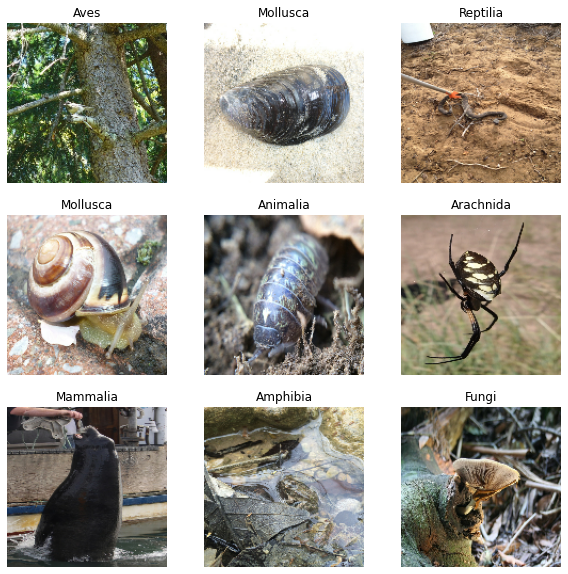

In [125]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [183]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))


Number of validation batches: 51
Number of test batches: 12


In [184]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)



In [185]:
#data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


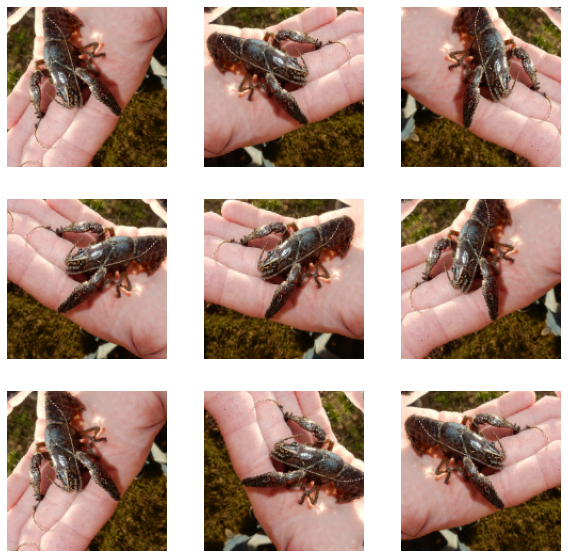

In [129]:
#see the augmented images
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [190]:
!wandb login 781ea05d3016dc46e417672b13ee6d7047c00562 

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [191]:
sweep_id = wandb.sweep(sweep_config,entity='akceg', project="cs6910-assignment2-pretrain") 

Create sweep with ID: l46dtvhz
Sweep URL: https://wandb.ai/akceg/cs6910-assignment2-pretrain/sweeps/l46dtvhz


In [192]:
def train():
  #wandb setup
  wandb.init()
  config = wandb.config
  n=str(config.model)+"_tune"+str(config.layers_freeze)+"_layrs"+str(config.dense_layers)+"_size"+str(config.size_layer)+"_drop"+str(config.dropout)
  wandb.run.name=n
  #preprocessing requires the function name of the model 
  classname="tf.keras.applications."
  #defaults
  modelnameproc="mobilenet_v2"
  modelname="MobileNetV2"
  attributes="(input_shape=(160,160,3),include_top=False,weights='imagenet',pooling='avg')"
  if config.model=="resnet":
    print("Resnet chosen")
    modelnameproc="resnet_v2"
    modelname="ResNet50V2"
  elif config.model=="xception":
    print("Xception chosen")
    modelnameproc="xception"
    modelname="Xception"
  elif config.model=="inceptionres":
    print("InceptionResnet")
    modelname="InceptionResNetV2"
    modelnameproc="inception_resnet_v2"
  elif config.model=="mobilenet":
    print("Mobilenet chosen")
    modelname="MobileNetV2"
    modelnameproc="mobilenet_v2"
  
  #preprocess layer
  preprocess_input = eval(classname+modelnameproc+".preprocess_input")
  #pretrained layers
  base_model = eval(classname+modelname+attributes)
  #freezing the layers 
  base_model.trainable = False
  #ouput layer 
  prediction_layer = tf.keras.layers.Dense(10,activation='softmax')
  #input layer 
  inputs = tf.keras.Input(shape=(160,160,3))
  #data augment
  x = data_augmentation(inputs)
  #preprocess 
  x = preprocess_input(x)

  x = base_model(x, training=False)
  #add a dropout layer 
  x = tf.keras.layers.Dropout(config.dropout)(x)
  #add dense layers paired with dropouts 
  for i in range(config.dense_layers):
    x=tf.keras.layers.Dense(config.size_layer,activation='relu')(x)
    x=tf.keras.layers.Dropout(config.dropout)(x)
  #output layer 
  outputs = prediction_layer(x) 
  model = tf.keras.Model(inputs, outputs)
  #set the learning rate 
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
  #number of epochs for pre training 
  initial_epochs = 10 
  history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,callbacks=[WandbCallback()])
  #Fine tuning if present
  if config.layers_freeze !=100:
    #unfreeze 
    base_model.trainable = True
    # Fine-tune from this layer onwards
    fine_tune_at = math.floor((config.layers_freeze/100.0)*len(base_model.layers))
  # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
      #freeze 
      layer.trainable =  False
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
                metrics=['accuracy'])
    #fine tune epochs 
    fine_tune_epochs = 10
    total_epochs =  initial_epochs + fine_tune_epochs
    history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1]+1,
                         validation_data=val_ds, callbacks=[WandbCallback()])
    test_loss, test_acc = model.evaluate(test_ds)
    print('Test accuracy :', test_acc)
    wandb.log({'test_accuracy': test_acc, 'test_loss': test_loss}) 


In [ ]:
wandb.agent(sweep_id, train,count=10)

wandb: Agent Starting Run: gaak4aya with config:
wandb: 	dense_layers: 2
wandb: 	dropout: 0.2
wandb: 	layers_freeze: 70
wandb: 	model: mobilenet
wandb: 	size_layer: 32
wandb: Currently logged in as: akceg (use `wandb login --relogin` to force relogin)


Mobilenet chosen
9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/10
313/313 [==============================] - 94s 281ms/step - loss: 2.3513 - accuracy: 0.1364 - val_loss: 1.9936 - val_accuracy: 0.3700
Epoch 2/10
 60/313 [====>.........................] - ETA: 55s - loss: 2.0749 - accuracy: 0.2572

12/12 [==============================] - 4s 228ms/step - loss: 1.0843 - accuracy: 0.6484
Test accuracy : 0.6484375
